- <a href='#1'>1. Introdução</a>  
- <a href='#2'>2. Importação das LIBS para visualização, manipulação do dataset, machine learning</a>
    - <a href='#2_1'>2.1 Vislumbre dos dados </a>
    - <a href='#2_2'>2.2 Observando as primeiras entradas do conjunto de dados</a>
    - <a href='#2_3'>2.3 Algumas estatístisticas descritivas dos dados</a>
- <a href='#3'>3. Checando por dados Nulos</a>
- <a href='#4'>4. Heurística para substituição dos valores nulos</a>
- <a href='#5'>5. Heurística para tratamento dos <i>outliers</i> </a>
    - <a href='#5-1'>5.1 Critério para substituição dos <i>outliers</i></a>
- <a href='#6'>7, Exploração dos Dados </a>    
    - <a href='#6-1'>6.1 Distribuição da Temperature</a>
    - <a href='#6-2'>6.2 Distribuição da Humidity</a>
    - <a href='#6-3'>6.3 Distribuição da Light</a>
    - <a href='#6-4'>6.4 Distribuição da Voltage</a>
    
- <a href='#7'>7, Criação do modelo </a>    
    - <a href='#7-1'>7.1, Modelo Temperatura ~ Humidade </a>    
    - <a href='#7-2'>7.2, Modelo Temperatura ~ Luminosidade </a>    
    - <a href='#7-3'>7.3, Modelo Temperatura ~ Voltagem </a>    
    
   

# <a id='1'> 1.Introdução</a>

# EDA do conjunto de dados de Sensor Readings


Os dados podem ser encontrados em http://db.csail.mit.edu/labdata/labdata.html

"Esta página contém informações sobre dados coletados de 54 sensores implantados no laboratório Intel Berkeley Research entre 28 de fevereiro e 5 de abril de 2004."

...

"Este arquivo inclui um registro de cerca de 2,3 milhões de leituras coletadas desses sensores. O arquivo é 34MB compactado, 150MB não tratado. O esquema é o seguinte:

data: aaaa-mm-dd
tempo: hh: mm: ss.xxx
época: int
moteid: int
temperatura: real
umidade: real
luz: real
voltagem: real

Neste caso, epoch é um número de sequência monotonicamente crescente de cada partícula. Duas leituras do mesmo número de época foram produzidas a partir de diferentes motivos ao mesmo tempo. Há algumas épocas ausentes neste conjunto de dados. Moteids variam de 1-54; dados de alguns motes podem estar ausentes ou truncados. A temperatura está em graus Celsius. A umidade é a umidade relativa corrigida pela temperatura, variando de 0 a 100%. A luz está no Lux (um valor de 1 Lux corresponde ao luar, 400 Lux a um escritório brilhante e 100.000 Lux a pleno sol). A voltagem é expressa em volts, variando de 2 a 3; as baterias, neste caso, eram células de íon de lítio que mantêm uma tensão bastante constante ao longo de sua vida útil; observe que variações na voltagem estão altamente correlacionadas com a temperatura. "

## O objetivo do trabalho é comparar o desempenho de quatros técnicas de aproximação de função
(por regressão, nesse caso) para estimar os valores de uma grandeza em pontos em cujas
coordenadas não há medição. Entendido o objetivo do trabalho, quaisquer outras decisões
necessárias para a sua realização, não dadas nesta descrição, são individuais do aluno. Isso
possibilitará que os trabalhos se diferenciem.


1. (pré-processamento dos dados) O dataset contém outliers e dados perdidos ou não
transmitidos. Existem vários métodos fundamentados publicados para tratamento de outliers e
dados perdidos. Neste exercício serão adotados métodos simples. Passo 1: Percorrer o data set e,
para quaisquer dados faltantes entre duas épocas com medições, preencher com a média das
medições reais das épocas anterior e posterior. Passo 2: Após preencher os dados faltantes, os
outliers detectados serão descartados e tratados como dados perdidos. Percorrer o data set na
ordem crescente das épocas e, para cada medição para a qual a diferença para a medição anterior
variar em mais que 10% do valor, considerar como outlier. Nesse caso, esse valor é considerado
perdido e substituído utilizando regra de valores perdidos do passo 1.


2. (aproximação por regressão linear ordinária) Obter, para cada época, o EQM (erro
quadrático médio) de estimação dos valores nos pontos dos nós sensores aproximando a função
subjacente por uma regressão linear de mínimos quadrados médios. Para calcular a média deve
ser utilizada cross validação leave-one-out. O desempenho final é a média dos EQMs sobre todas
as épocas. A saída deste item é um gráfico 3D mostrando claramente as medições verdadeiras em
cada ponto dos nós sensores e a superfície da função de estimação. O processamento é
independente para cada grandeza sensorizada (temperatura, umidade e luminosidade).


3. (aproximação kriging simples) Repetir o item 2 aproximando a função subjacente por
uma regressão kriging simples.


4. (aproximação regressão kernel) Repetir o item 2 aproximando a função subjacente
por uma regressão kernel Nadaraya-Watson. Note que neste caso há parâmetro a sintonizar.


5. (aproximação regressão fuzzy) Repetir o item 2 aproximando a função subjacente por
uma regressão de mínimos quadrados fuzzy. Note que neste caso há parâmetros a sintonizar.

# <a id='2'> 2. Importação das LIBS para visualização, manipulação do dataset, machine learning</a> 


In [2]:
%matplotlib inline
import scipy as sp
import scipy.linalg
import numpy as np
import scipy as sp
import scipy.stats as stats
import scipy.linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
import random as rdn
import datetime
import time

In [3]:
import matplotlib.pyplot as plt # for plotting
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression 
from sklearn import linear_model
from __future__ import division 
import sklearn.manifold as skm
from sklearn import metrics

### Ignorando mensagens warnings 

In [5]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from sklearn import preprocessing, metrics


In [6]:
#### Leitura dos dados
data_column_names = ["Date", "Time", "Epoch", "Moteid", "Temperature", "Humidity", "Light", "Voltage"]
data_ = pd.read_csv("dataset/data.txt", delimiter = " ", names = data_column_names)

In [7]:
pos_col_names = ["Moteid", "X", "Y"]
pos_data = pd.read_csv("dataset/coords.txt", delimiter = " ", names = pos_col_names)

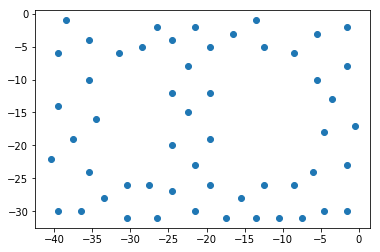

In [8]:
xCord = pos_data["X"] * -1
yCord = pos_data["Y"] * -1
plt.scatter(xCord, yCord)

In [10]:
print(data_.shape, pos_data.shape)

(2313682, 8) (54, 3)


In [9]:
data = pd.merge(data_, pos_data, how='left', on='Moteid' )
data.shape

(2313682, 10)

In [17]:
data.head()

,Date,Time,Epoch,Moteid,Temperature,Humidity,Light,Voltage,X,Y
0,2004-03-31,03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397,21.5,23.0
1,2004-02-28,00:59:16.02785,3,1.0,19.9884,37.09330,45.08,2.69964,21.5,23.0
2,2004-02-28,01:03:16.33393,11,1.0,19.3024,38.46290,45.08,2.68742,21.5,23.0
3,2004-02-28,01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742,21.5,23.0
4,2004-02-28,01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964,21.5,23.0


## Pegando as épocas exceto a 1°   

In [10]:
data = data[(data["Epoch"] <= 5576) & (data["Epoch"] > 1)]

# <a id='#2_1'>2.1 Vislumbre dos Dados </a>

### Observando o tipo de cada coluna
Tamanho do conjunto de dados: 2.313.682 entradas e 8 variáveis.
Variáveis:
`Date` , ` Time`/; são timestamps para as leituras em cada linha.

`Epoch`: é "um número de sequência monotonicamente crescente de cada partícula. Duas leituras do mesmo número de época foram produzidas a partir de diferentes motivos ao mesmo tempo."

`Moteid`: corresponde ao id de cada sensor implantado, variando de 1 a 54.

`Temperature`,` Humidity`, `Light` e` Voltage`/; são os valores de leitura do sensor.


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188392 entries, 0 to 2313393
Data columns (total 10 columns):
Date           188392 non-null object
Time           188392 non-null object
Epoch          188392 non-null int64
Moteid         188155 non-null float64
Temperature    188129 non-null float64
Humidity       188130 non-null float64
Light          182313 non-null float64
Voltage        188155 non-null float64
X              187565 non-null float64
Y              187565 non-null float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.8+ MB


# <a id='#2_2'>2.2 Observando as primeiras entradas do conjunto de dados </a>

In [20]:
data.head()

,Date,Time,Epoch,Moteid,Temperature,Humidity,Light,Voltage,X,Y
0,2004-03-31,03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397,21.5,23.0
1,2004-02-28,00:59:16.02785,3,1.0,19.9884,37.09330,45.08,2.69964,21.5,23.0
2,2004-02-28,01:03:16.33393,11,1.0,19.3024,38.46290,45.08,2.68742,21.5,23.0
3,2004-02-28,01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742,21.5,23.0
4,2004-02-28,01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964,21.5,23.0


# <a id='#2_3'>2.3 Algumas estatístisticas descritivas dos dados </a>

## Count, mean, std, min, 25%, 50%, 75%, max 

In [9]:
data.loc[:, ('Temperature', 'Humidity', 'Light', 'Voltage')].describe()

,Temperature,Humidity,Light,Voltage
count,188129.000000,188130.000000,1.823130e+05,188155.000000
mean,20.946464,39.663786,4.057944e+02,2.656486
std,11.321900,8.115080,5.185346e+02,0.096088
min,-38.400000,-1854.520000,3.077160e-15,0.018037
25%,17.852000,37.607900,6.440000e+01,2.639640
50%,19.380800,40.568000,1.656000e+02,2.675320
75%,21.438800,43.185800,5.372800e+02,2.699640
max,122.153000,114.894000,1.847360e+03,3.193120


### Média de cada leitura para os 10 primeiros sensores

In [22]:
data.groupby("Moteid").mean()[:10]

,Epoch,Temperature,Humidity,Light,Voltage,X,Y
Moteid,,,,,,,
1.0,3030.573373,20.344382,38.560681,148.394900,2.691008,21.5,23.0
2.0,3189.872296,20.278749,39.310874,233.526575,2.650400,24.5,20.0
3.0,2929.503568,20.458160,38.807569,145.998721,2.681378,19.5,19.0
4.0,2810.369482,20.282955,39.191980,180.014351,2.658232,22.5,15.0
5.0,2342.411765,NaN,NaN,NaN,2.633605,24.5,12.0
6.0,2830.444444,19.803932,39.288409,462.139957,2.635130,19.5,12.0
7.0,2796.575379,19.853478,39.074284,193.144521,2.676567,22.5,8.0
8.0,2779.908264,19.978724,39.173046,795.753493,2.667634,24.5,4.0
9.0,2755.480332,19.602967,40.493383,744.088355,2.755851,21.5,2.0


# <a id='#3'>3 Checando por dados Nulos </a>

Text(0,0.5,'Percentage')

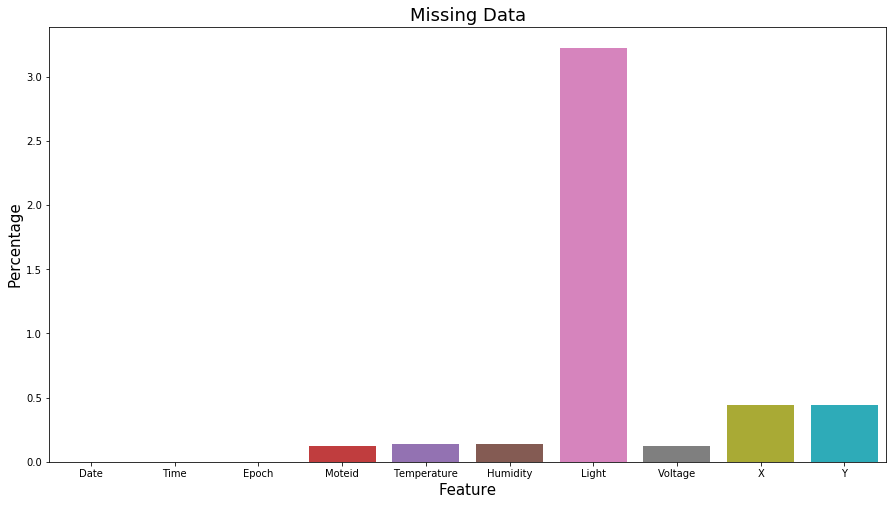

In [39]:
missing = pd.DataFrame((data.isnull().sum() * 100 )/ data.shape[0]).reset_index().rename(columns = {'index': 'Feature', 0: 'Percent'})
p = sns.barplot(x = 'Feature', y = 'Percent', data = missing, ax = plt.subplots(figsize = (15, 8))[1])
p.set_title('Missing Data', fontsize = 18)
p.set_xlabel('Feature', fontsize = 15)
p.set_ylabel('Percentage', fontsize = 15)

In [24]:
pd.isnull(data).any()

Date           False
Time           False
Epoch          False
Moteid          True
Temperature     True
Humidity        True
Light           True
Voltage         True
X               True
Y               True
dtype: bool

In [40]:
# checking missing data
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
missing_new_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_new_data.head(10)

,Total,Percent
Light,6079,3.226782
Y,827,0.438978
X,827,0.438978
Temperature,263,0.139603
Humidity,262,0.139072
Voltage,237,0.125802
Moteid,237,0.125802
Epoch,0,0.000000
Time,0,0.000000
Date,0,0.000000


## Mudando a ordem das colunas

In [43]:
# change features order

# data = data[["Moteid", "X", "Y", "Epoch", "Humidity", "Light", "Voltage", "Date", "Time", "Temperature"]]

,Moteid,Epoch,Humidity,Light,Voltage,Date,Time,Temperature
0,1.0,2,-3.91901,11.04,2.03397,2004-03-31,03:38:15.757551,122.1530
1,1.0,3,37.09330,45.08,2.69964,2004-02-28,00:59:16.02785,19.9884
2,1.0,11,38.46290,45.08,2.68742,2004-02-28,01:03:16.33393,19.3024
3,1.0,17,38.80390,45.08,2.68742,2004-02-28,01:06:16.013453,19.1652
4,1.0,18,38.83790,45.08,2.69964,2004-02-28,01:06:46.778088,19.1750


<!-- <a href='#5'>5. Heurística para tratamento dos <i>outliers</i> </a> -->
# <a id='#4'>4. Heurística para substuição dos dados nulos </a>



## Criando um Dataframe com médias

Creating a dataframe $means\_epochs$, where epoch in [2, 5576] and feature in ["Temperature", "Humidity", "Light", "Voltage"]

In [11]:
# percorrendo as features
epocas = np.sort(data["Epoch"].unique())
means = {"Temperature": [], "Humidity": [], "Light": [], "Voltage": []}
for feature in ["Temperature", "Humidity", "Light", "Voltage"]:   
    for epoch in epocas:
        means[feature].append(data[data['Epoch'] == epoch][feature].mean())
        
means_epochs = pd.DataFrame(means).set_index(epocas).reset_index().rename(columns = {'index': 'Epoch'})

## Substituindo os valores nulos de cada época pela média da época posterior e anterior.
### Para a 1° época substituimos os valores nulos pela média dos valores da época posterior.
### Para a última época substituimos os valores nulos pela média dos valores da penúltima época.

Replacing missing data by mean combining feature $f_i$ and epoch $epo_i$

In [12]:
# parsing in the features
for feature in ["Temperature", "Humidity", "Light", "Voltage"]:
    # first epoch
    aux = data[data['Epoch'] == 2].copy()
    index_ = aux[aux[feature].isnull()].index
    data.loc[index_, feature] = means_epochs[means_epochs['Epoch'] == 3][feature].values[0]
    
    # last epoch
    aux = data[data['Epoch'] == 5576].copy()
    index_ = aux[aux[feature].isnull()].index
    data.loc[index_, feature] = means_epochs[means_epochs['Epoch'] == 5575][feature].values[0]
    
    for epoch in range(1, len(epocas) - 1):
        aux = data[data['Epoch'] == epocas[epoch]].copy()
        index_ = aux[aux[feature].isnull()].index
        
        data.loc[index_, feature] = (means_epochs[means_epochs['Epoch'] == epocas[epoch - 1]][feature].values[0] + \
                                    means_epochs[means_epochs['Epoch'] == epocas[epoch + 1]][feature].values[0]) / 2

# <a id='#5'>5. Heurística para tratamento dos <i>outliers</i> </a> 

In [13]:
outliers = data.copy()
print(outliers.shape)
outliers.head(2)

(188392, 10)


,Date,Time,Epoch,Moteid,Temperature,Humidity,Light,Voltage,X,Y
0,2004-03-31,03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397,21.5,23.0
1,2004-02-28,00:59:16.02785,3,1.0,19.9884,37.09330,45.08,2.69964,21.5,23.0


# Vamos observar para cada feature a distribuição dos dados com base no gráfico Boxplot.

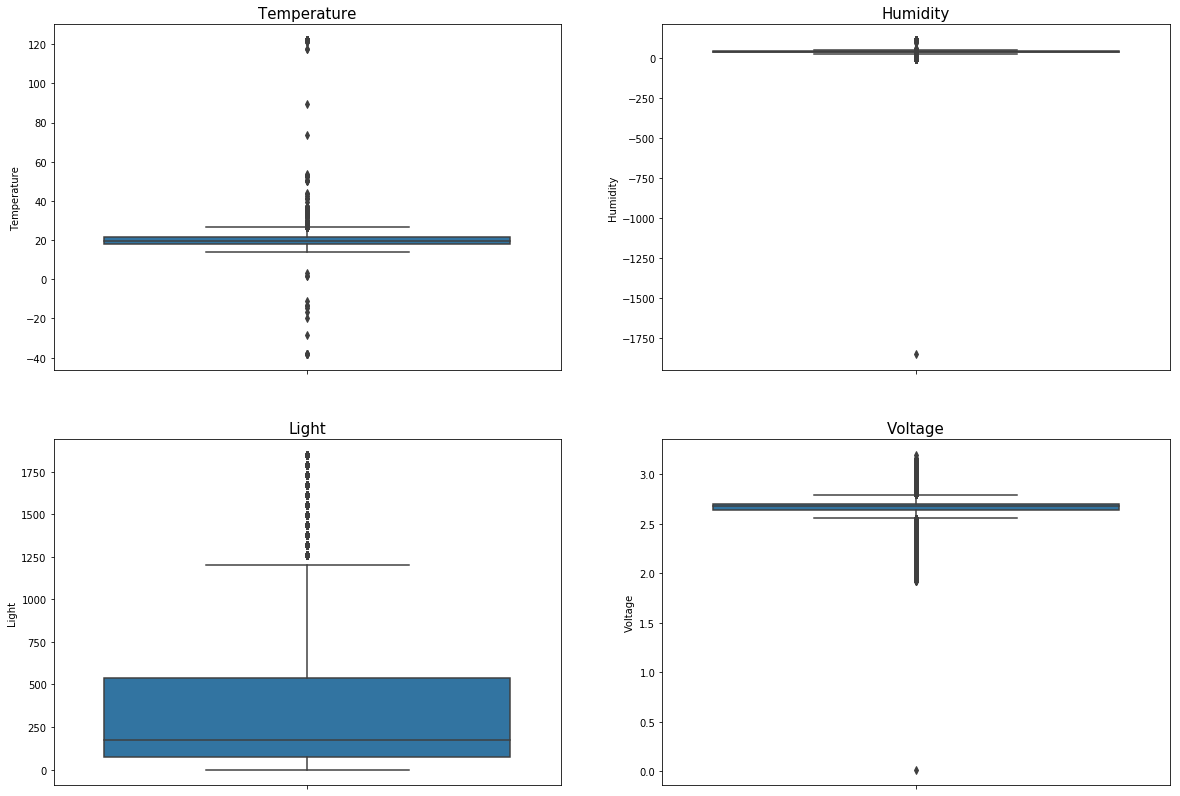

In [45]:

# plotting outliers# plotti 
fig, ax = plt.subplots(nrows = 2, ncols = 2, sharex = True, figsize = (20, 14))

feature = ["Temperature", "Humidity", "Light", "Voltage"]; indx = 0
for i in [0, 1]:
    for j in [0, 1]:
        ax[i, j].set_title(feature[indx], fontsize = 15)
        p = sns.boxplot(y = feature[indx], data = outliers, ax = ax[i, j])
        indx += 1

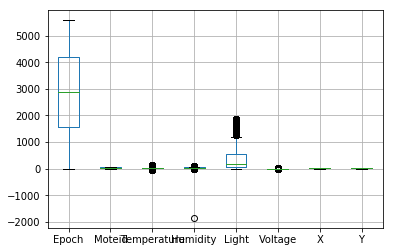

In [46]:
_, bp = pd.DataFrame.boxplot(outliers, return_type='both')

out = [flier.get_ydata() for flier in bp["fliers"]]
boxes = [box.get_ydata() for box in bp["boxes"]]
medians = [median.get_ydata() for median in bp["medians"]]
whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]

###### Como opção podemos salvar a imagem como:

In [47]:
# # output file name
# plot_file_name="boxplot_and_swarmplot_with_seaborn.jpg"
 
# # save as jpeg
# ax.figure.savefig(plot_file_name,
#                     format='jpeg',
#                     dpi=100)
print("Amount of rows")
print("before removing outliers: {}".format(outliers.shape[0]))
print("after removing outliers: {}".format(data.shape[0]))

Amount of rows
before removing outliers: 188392
after removing outliers: 188392



Replacing outliers
Removing rows with values $\notin$ $[-3\sigma + \mu , \mu + 3\sigma]$

## Buscaremos encontrar os outliers com um desvio padrão alto em relação a média para cada feature.
### Estabelecemos um threshold para cada feature com base na distribuição dos dados visto acima com o boxplot

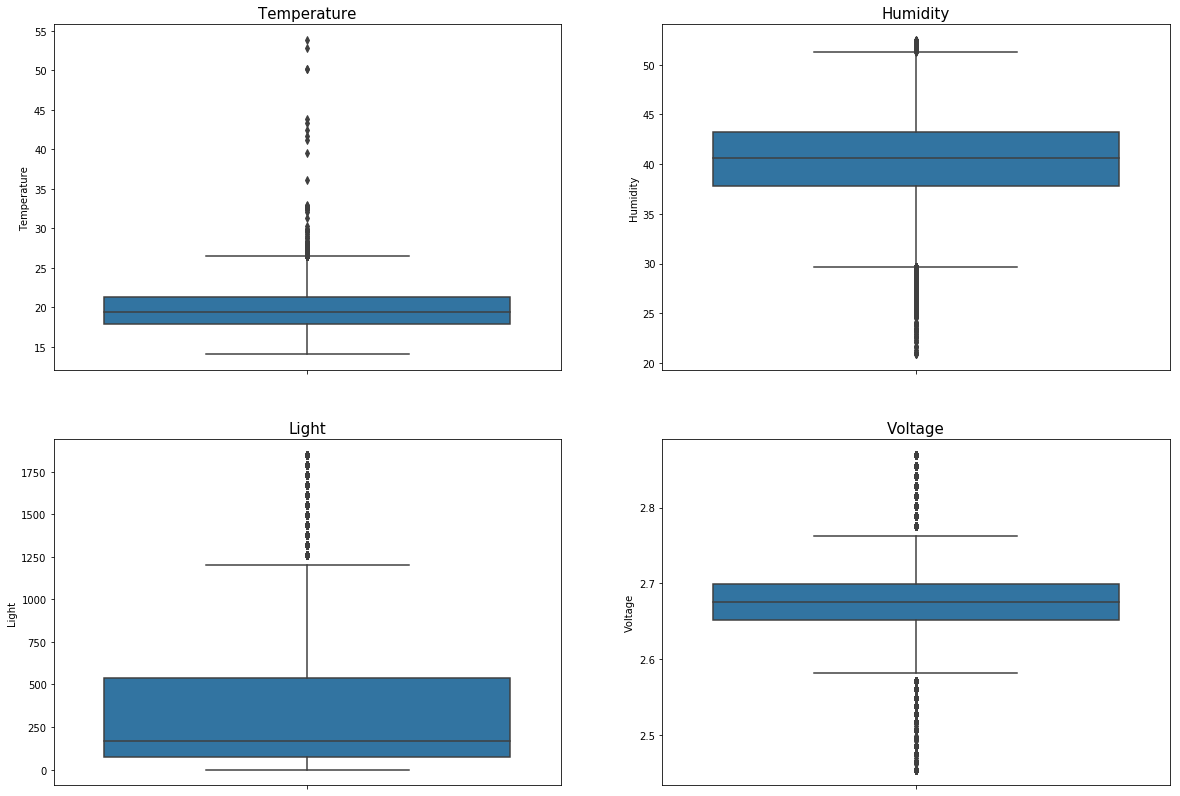

In [48]:
#https://pt.wikipedia.org/wiki/Amplitude_interquartil
# Removendo outliers
# for feature in ["Temperature", "Humidity", "Light", "Voltage"]:
#     data = data[np.abs(data[feature] - data[feature].mean()) <= 3 * data[feature].std()].copy()
    
    # plotting outliers
fig, ax = plt.subplots(nrows = 2, ncols = 2, sharex = True, figsize = (20, 14))

feature = ["Temperature", "Humidity", "Light", "Voltage"]; indx = 0
for i in [0, 1]:
    for j in [0, 1]:
        ax[i, j].set_title(feature[indx], fontsize = 15)
        p = sns.boxplot(y = feature[indx], data = data, ax = ax[i, j])
        indx += 1

In [50]:
print("Amount of rows")
print("before removing outliers: {}".format(outliers.shape[0]))
print("after removing outliers: {}".format(data.shape[0]))

Amount of rows
before removing outliers: 188392
after removing outliers: 183865


OBS.: Light didn't change

 # <a id='#5-1'>5.1 Critério para substituição dos <i>outliers</i></a>
 
 #### Criamos 4 colunas que representam a diferença entre os valores de medição para cada grandeza
 Replacing outliers
Removing rows with values $\notin$ $[-3\sigma + \mu , \mu + 3\sigma]$


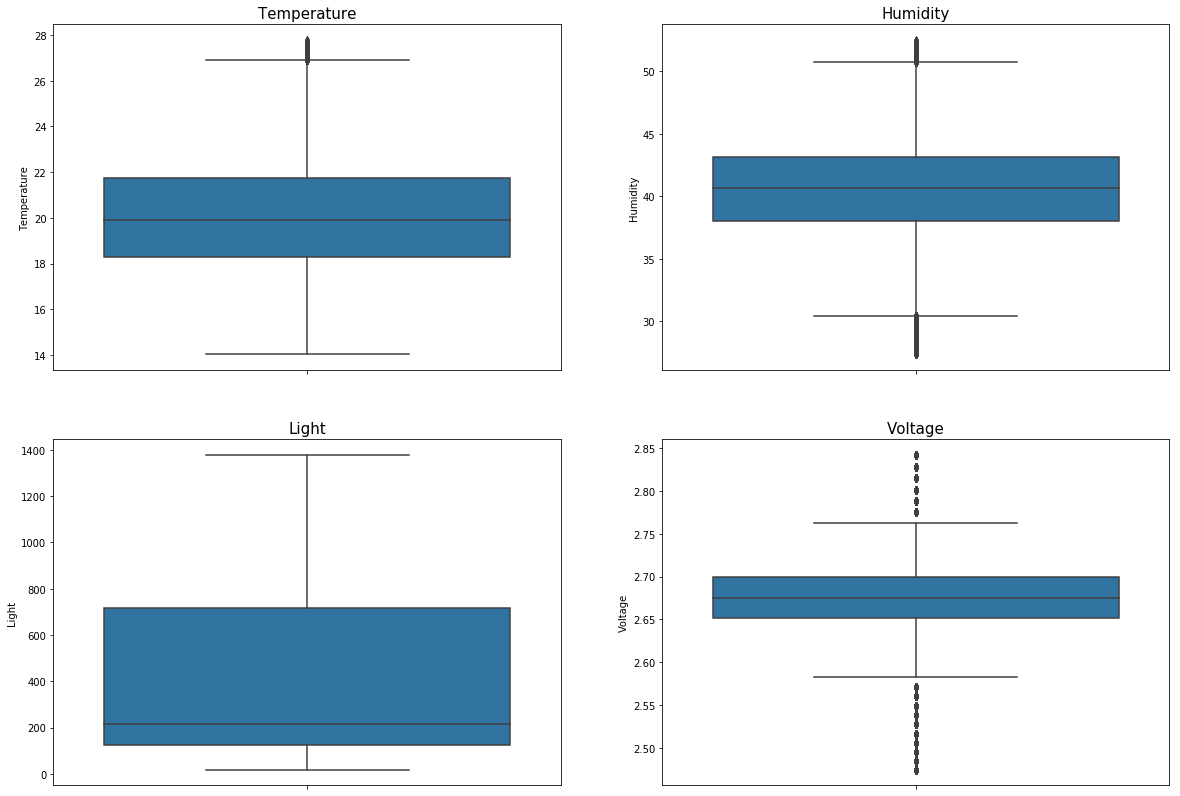

In [51]:
for epo in epocas:
    for feature in ["Temperature", "Humidity", "Light", "Voltage"]:
        
        mean_ = means_epochs.query('Epoch == {}'.format(epo))[feature].values[0]
        index_data = data[data['Epoch'] == epo][feature].index
        
        for ind in range(1, len(index_data)):
            variation = np.abs(data.loc[index_data[ind - 1], feature] - data.loc[index_data[ind], feature])/data.loc[index_data[ind - 1], feature]
            if variation > 0.1:
                data.loc[index_data[ind], feature] = mean_
                indx += 1
for feature in ["Temperature", "Humidity", "Light", "Voltage"]:
    data = data[np.abs(data[feature] - data[feature].mean()) <= 3 * data[feature].std()].copy()

# plotting outliers
fig, ax = plt.subplots(nrows = 2, ncols = 2, sharex = True, figsize = (20, 14))

feature = ["Temperature", "Humidity", "Light", "Voltage"]; indx = 0
for i in [0, 1]:
    for j in [0, 1]:
        ax[i, j].set_title(feature[indx], fontsize = 15)
        p = sns.boxplot(y = feature[indx], data = data, ax = ax[i, j])
        indx += 1

In [52]:
print("Amount of rows in the final: {}".format(data.shape[0]))

Amount of rows in the final: 182034


# <a id='#6'>6. Exploração dos Dados </a>    


#     <a id='#6-1'>6.1 Distribuição da Temperature</a>
    

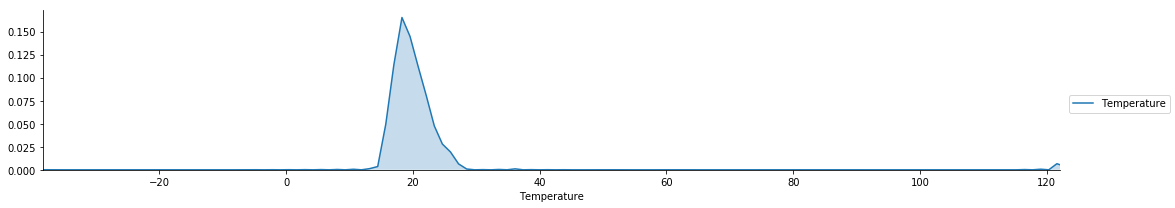

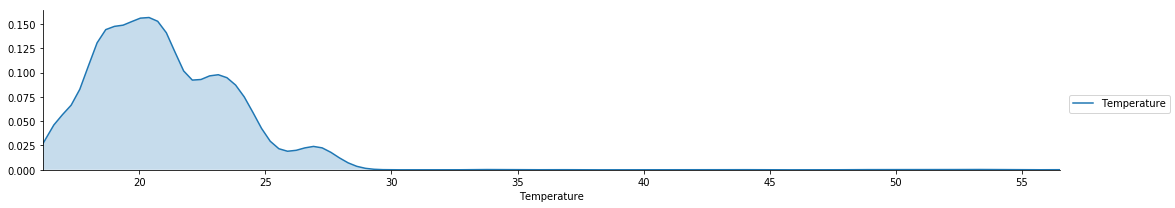

In [106]:
facet = sns.FacetGrid(data, palette = "seismic", aspect=5)
facet.map(sns.kdeplot, 'Temperature', shade=True)
facet.set(xlim=(data["Temperature"].min(), data["Temperature"].max()))
facet.add_legend()

facet = sns.FacetGrid(means_epochs, palette = "seismic", aspect=5)
facet.map(sns.kdeplot, 'Temperature', shade=True)
facet.set(xlim=(means_epochs["Temperature"].min(), means_epochs["Temperature"].max()))
facet.add_legend()

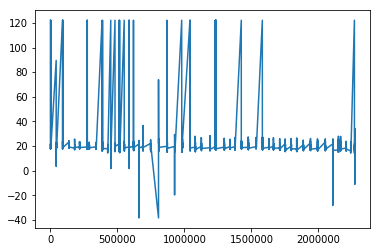

In [113]:
data_["Temperature"].plot()

#     <a id='#6-2'>6.2 Distribuição da Humidity</a>
    

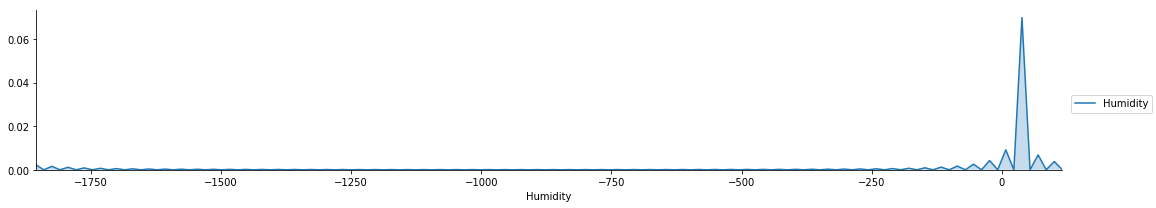

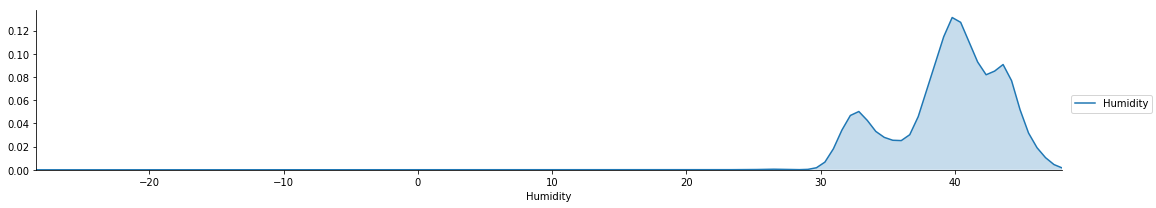

In [107]:
facet = sns.FacetGrid(data, palette = "seismic", aspect=5)
facet.map(sns.kdeplot, 'Humidity', shade=True)
facet.set(xlim=(data["Humidity"].min(), data["Humidity"].max()))
facet.add_legend()

facet = sns.FacetGrid(means_epochs, palette = "seismic", aspect=5)
facet.map(sns.kdeplot, 'Humidity', shade=True)
facet.set(xlim=(means_epochs["Humidity"].min(), means_epochs["Humidity"].max()))
facet.add_legend()

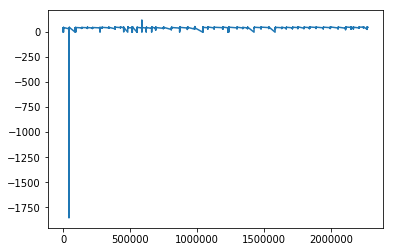

In [112]:
data_["Humidity"].plot()

#     <a id='#6-3'>6.3 Distribuição da Light</a>
   

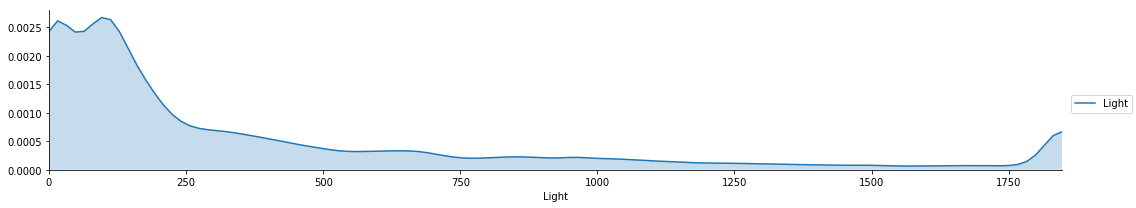

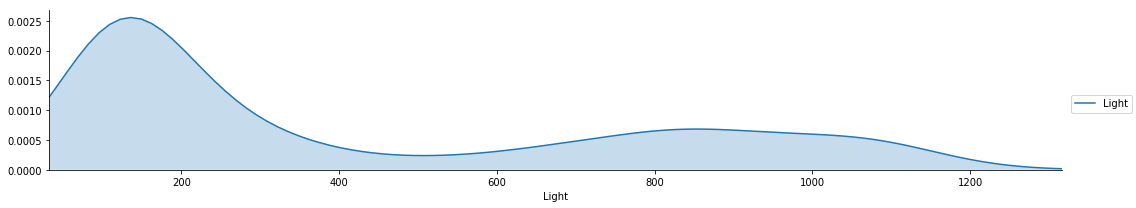

In [108]:
facet = sns.FacetGrid(data, palette = "seismic", aspect=5)
facet.map(sns.kdeplot, 'Light', shade=True)
facet.set(xlim=(data["Light"].min(), data["Light"].max()))
facet.add_legend()

facet = sns.FacetGrid(means_epochs, palette = "seismic", aspect=5)
facet.map(sns.kdeplot, 'Light', shade=True)
facet.set(xlim=(means_epochs["Light"].min(), means_epochs["Light"].max()))
facet.add_legend()

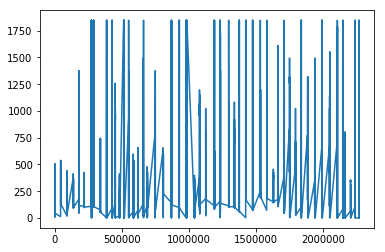

In [111]:
data_["Light"].plot()

#   <a id='#6-4'>6.4 Distribuição da Voltage</a>
   

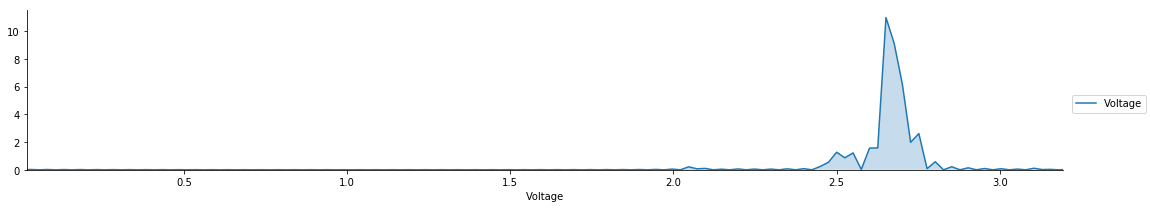

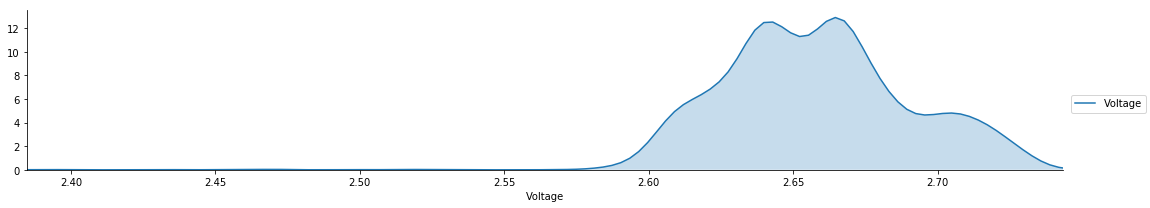

In [109]:
facet = sns.FacetGrid(data, palette = "seismic", aspect=5)
facet.map(sns.kdeplot, 'Voltage', shade=True)
facet.set(xlim=(data["Voltage"].min(), data["Voltage"].max()))
facet.add_legend()

facet = sns.FacetGrid(means_epochs, palette = "seismic", aspect=5)
facet.map(sns.kdeplot, 'Voltage', shade=True)
facet.set(xlim=(means_epochs["Voltage"].min(), means_epochs["Voltage"].max()))
facet.add_legend()

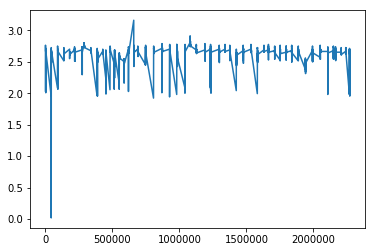

In [110]:
data_["Voltage"].plot()

# <a href='#7'>7 Criação do modelo </a>

# <a id='#7-1'>7.1 Modelo Humidade </a>

In [14]:
# adding coordanates in the dataset
data_ = data[~(data['X'].isnull()) | ~(data['Y'].isnull())] # removing null lines

data_.to_pickle("dataset/data.pkl")
# data_ = pd.read_pickle("dataset/data.pkl")

### Instanciando o modelo

In [15]:
X2 = data_[['X', 'Y']]
y2 = data_['Humidity']
regr2 = LinearRegression()
regr2.fit(X2, y2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
aux = data_[data_['Epoch']==2504]
X2 = aux[['X', 'Y']].values
y2 = aux['Humidity'].values
regr2 = LinearRegression()
regr2.fit(X2, y2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [75]:
y2_hat = regr2.coef_[0]* X2[:,0] + regr2.coef_[1]* X2[:,1] + regr2.intercept_ ##
# print(y2_hat)
erro = (y2_hat - y2)**2
print(np.mean(erro) ) #, erro)

2.1749632190255155


## Calculando o Erro média de Todas as épocas

In [75]:
count = 0
mean_epoch=[] # erro média de cada sensor em cada época
mean_epoch2=[] # média de todas as épocas

for i in data_.Epoch.unique():
    aux = data_[data_['Epoch']==i]
    scores = cross_val_score(regr2, X2, y2, cv=aux.shape[0], scoring='mean_squared_error')
    y_pred = cross_val_predict(regr2, X2, y2, cv=aux.shape[0])
    mean_epoch2.append(abs(scores).mean()) 
    mean_epoch.append(abs(scores)) 
    count+=1
    if count== 5574:
        break
print("Vetor de erros médias para a epoca 2504 ", np.mean(mean_epoch2))

Vetor de erros médias para a epoca 2504  47.624476429679426


In [90]:
menorNumero = min(numero for numero in mean_epoch2 if numero != 0)
indiceDoMenorNumero = mean_epoch2.index(menorNumero)

# A época 6 possui o menor erro médio para a Humidade

In [92]:
print("Erro médio de exemplo para a época com menor erro médio usando leave on out nos sensores ", menorNumero, indiceDoMenorNumero )

Erro médio de exemplo para a época com menor erro médio usando leave on out nos sensores  36.79647875297098 6


# Plot do modelo Com a época que tem o menor erro na validação

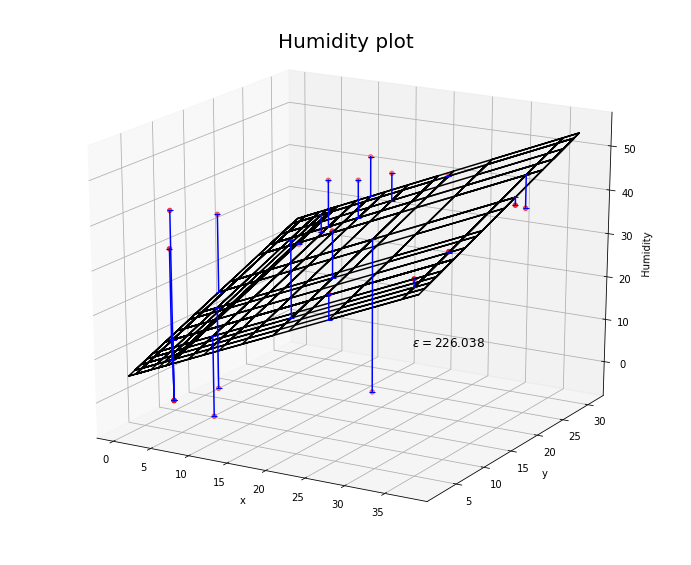

In [93]:

grandeza = 'Humidity'
number_ep = 6 
test = data_[data_['Epoch'] == number_ep].copy()

models = {} # a list of regression models
for feature in ["Temperature", "Humidity", "Light", "Voltage"]:
    regr = LinearRegression() # Linear Regression
    models[feature] = regr.fit(test[['X', 'Y']], test[feature])
regr = models[grandeza]

X = []
for x, y in zip (data_[data_['Epoch'] == number_ep]['X'].values,  data_[data_['Epoch'] == number_ep]['Y'].values):
    X.append([x, y])

X = np.array(X)
Z = np.array(data_[data_['Epoch'] == number_ep][grandeza].values)

X_, Y_ = np.meshgrid(X[:, 0], X[:, 1])  # Criando uma malha de pontos para o plot.
Z_hat = regr.coef_[0] * X_ + regr.coef_[1] * Y_ + regr.intercept_

# calculating the mean sqarred error
error = []
for i in range(Z.shape[0]):
    error.append(Z_hat[i, i] - Z[i])

error = np.array(error) ** 2
error = error.mean()

# settings
# plot raw data
plt.figure(figsize = (12, 10))
ax = plt.subplot(111, projection = '3d')
ax.scatter(X[:, 0], X[:, 1], Z, marker = 'o', c = 'r')
ax.plot_wireframe(X_, Y_, Z_hat, color = 'k')

# creating the points of the plot
# each column are a point
xx = X[:, 0]
yy = X[:, 1]
for i in range(xx.shape[0]):
    ax.plot([xx[i], xx[i]] , [yy[i],yy[i]], [Z[i] , Z_hat[i, i]], marker="_", color = 'b')
    # [1 xx[i], 2 xx[i]] [ 3 yy[i], 4 yy[i]] [ 5 Z[i] , 6 Z_hat[i, i]] captura os valores para as 1,2,3 dimenssões
    # 1 ponto (1,3, 5) 2 ponto (2, 4, 6) 

ax.set_title(grandeza+" plot", fontsize = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(grandeza)
ax.view_init(20, -60)
ax.text(20, 25, 2.80, r" $\epsilon = {e}$".format(e = round(error, 3)), color = 'k', fontsize =12)
plt.show()

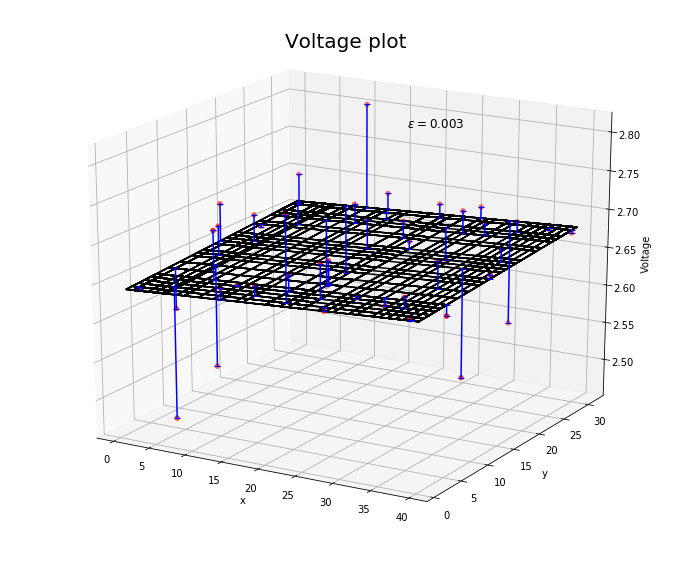

In [87]:
grandeza = 'Voltage'
number_ep = 2504 
test = data_[data_['Epoch'] == number_ep].copy()

models = {} # a list of regression models
for feature in ["Temperature", "Humidity", "Light", "Voltage"]:
    regr = LinearRegression() # Linear Regression
    models[feature] = regr.fit(test[['X', 'Y']], test[feature])
regr = models[grandeza]

X = []
for x, y in zip (data_[data_['Epoch'] == number_ep]['X'].values,  data_[data_['Epoch'] == number_ep]['Y'].values):
    X.append([x, y])
X = np.array(X)
Z = np.array(data_[data_['Epoch'] == number_ep][grandeza].values)

X_, Y_ = np.meshgrid(X[:, 0], X[:, 1])  # Criando uma malha de pontos para o plot.
Z_hat = regr.coef_[0] * X_ + regr.coef_[1] * Y_ + regr.intercept_

# calculating the mean sqarred error
error = []
for i in range(Z.shape[0]):
    error.append(Z_hat[i, i] - Z[i])

error = np.array(error) ** 2
error = error.mean()

# settings
# plot raw data
plt.figure(figsize = (12, 10))
ax = plt.subplot(111, projection = '3d')
ax.scatter(X[:, 0], X[:, 1], Z, marker = 'o', c = 'r')
ax.plot_wireframe(X_, Y_, Z_hat, color = 'k')

# creating the points of the plot
# each column are a point
xx = X[:, 0]
yy = X[:, 1]
for i in range(xx.shape[0]):
    ax.plot([xx[i], xx[i]] , [yy[i],yy[i]], [Z[i] , Z_hat[i, i]], marker="_", color = 'b')
    # [1 xx[i], 2 xx[i]] [ 3 yy[i], 4 yy[i]] [ 5 Z[i] , 6 Z_hat[i, i]] captura os valores para as 1,2,3 dimenssões
    # 1 ponto (1,3, 5) 2 ponto (2, 4, 6) 

ax.set_title(grandeza+" plot", fontsize = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(grandeza)
ax.view_init(20, -60)
ax.text(20, 25, 2.80, r" $\epsilon = {e}$".format(e = round(error, 3)), color = 'k', fontsize =12)
plt.show()

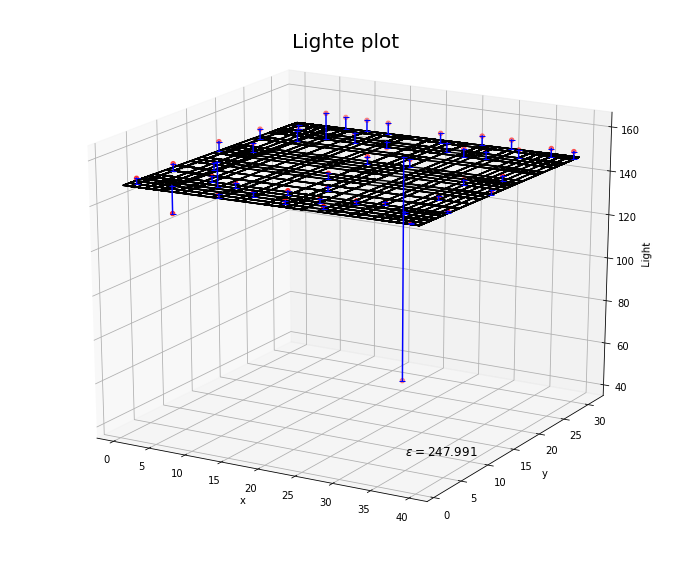

In [88]:
grandeza = 'Light'
number_ep = 2504 
test = data_[data_['Epoch'] == number_ep].copy()

models = {} # a list of regression models
for feature in ["Temperature", "Humidity", "Light", "Voltage"]:
    regr = LinearRegression() # Linear Regression
    models[feature] = regr.fit(test[['X', 'Y']], test[feature])
regr = models[grandeza]

X = []
for x, y in zip (data_[data_['Epoch'] == number_ep]['X'].values,  data_[data_['Epoch'] == number_ep]['Y'].values):
    X.append([x, y])

X = np.array(X)
Z = np.array(data_[data_['Epoch'] == number_ep][grandeza].values)

X_, Y_ = np.meshgrid(X[:, 0], X[:, 1])  # Criando uma malha de pontos para o plot.
Z_hat = regr.coef_[0] * X_ + regr.coef_[1] * Y_ + regr.intercept_

# calculating the mean sqarred error
error = []
for i in range(Z.shape[0]):
    error.append(Z_hat[i, i] - Z[i])

error = np.array(error) ** 2
error = error.mean()

# settings
# plot raw data
plt.figure(figsize = (12, 10))
ax = plt.subplot(111, projection = '3d')
ax.scatter(X[:, 0], X[:, 1], Z, marker = 'o', c = 'r')
ax.plot_wireframe(X_, Y_, Z_hat, color = 'k')

# creating the points of the plot
# each column are a point
xx = X[:, 0]
yy = X[:, 1]
for i in range(xx.shape[0]):
    ax.plot([xx[i], xx[i]] , [yy[i],yy[i]], [Z[i] , Z_hat[i, i]], marker="_", color = 'b')
    # [1 xx[i], 2 xx[i]] [ 3 yy[i], 4 yy[i]] [ 5 Z[i] , 6 Z_hat[i, i]] captura os valores para as 1,2,3 dimenssões
    # 1 ponto (1,3, 5) 2 ponto (2, 4, 6) 

ax.set_title(grandeza+"e plot", fontsize = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(grandeza)
ax.view_init(20, -60)
ax.text(20, 25, 2.80, r" $\epsilon = {e}$".format(e = round(error, 3)), color = 'k', fontsize =12)
plt.show()

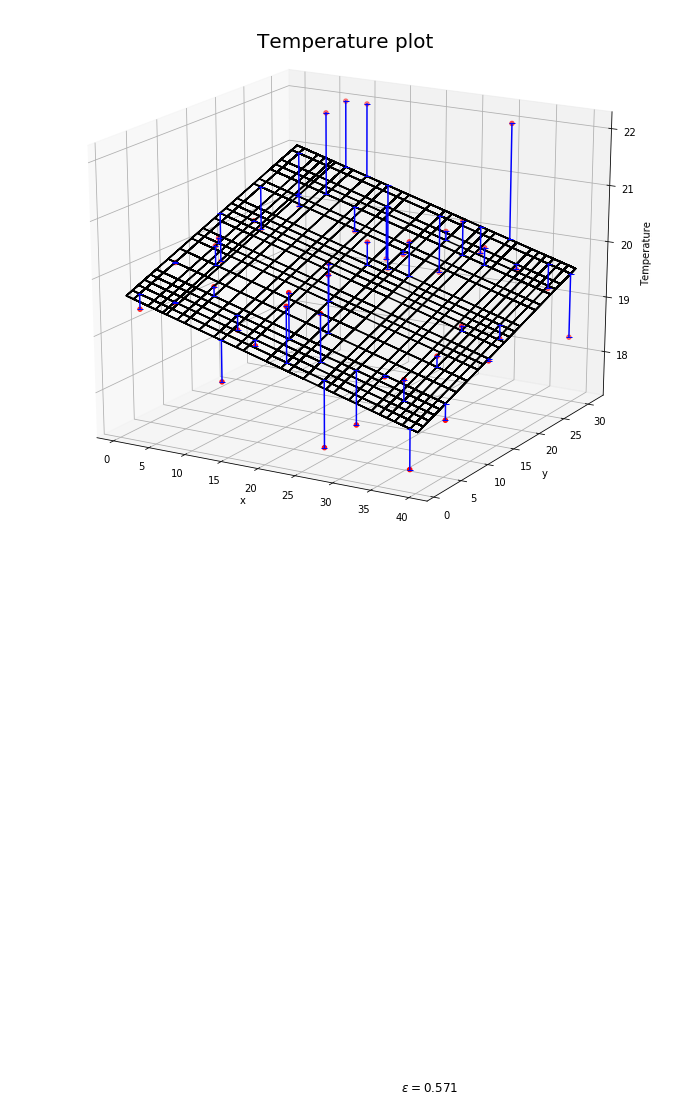

In [89]:
grandeza = 'Temperature'
number_ep = 2504 
test = data_[data_['Epoch'] == number_ep].copy()

models = {} # a list of regression models
for feature in ["Temperature", "Humidity", "Light", "Voltage"]:
    regr = LinearRegression() # Linear Regression
    models[feature] = regr.fit(test[['X', 'Y']], test[feature])
regr = models[grandeza]

X = []
for x, y in zip (data_[data_['Epoch'] == number_ep]['X'].values,  data_[data_['Epoch'] == number_ep]['Y'].values):
    X.append([x, y])

X = np.array(X)
Z = np.array(data_[data_['Epoch'] == number_ep][grandeza].values)

X_, Y_ = np.meshgrid(X[:, 0], X[:, 1])  # Criando uma malha de pontos para o plot.
Z_hat = regr.coef_[0] * X_ + regr.coef_[1] * Y_ + regr.intercept_

# calculating the mean sqarred error
error = []
for i in range(Z.shape[0]):
    error.append(Z_hat[i, i] - Z[i])

error = np.array(error) ** 2
error = error.mean()

# settings
# plot raw data
plt.figure(figsize = (12, 10))
ax = plt.subplot(111, projection = '3d')
ax.scatter(X[:, 0], X[:, 1], Z, marker = 'o', c = 'r')
ax.plot_wireframe(X_, Y_, Z_hat, color = 'k')

# creating the points of the plot
# each column are a point
xx = X[:, 0]
yy = X[:, 1]
for i in range(xx.shape[0]):
    ax.plot([xx[i], xx[i]] , [yy[i],yy[i]], [Z[i] , Z_hat[i, i]], marker="_", color = 'b')
    # [1 xx[i], 2 xx[i]] [ 3 yy[i], 4 yy[i]] [ 5 Z[i] , 6 Z_hat[i, i]] captura os valores para as 1,2,3 dimenssões
    # 1 ponto (1,3, 5) 2 ponto (2, 4, 6) 

ax.set_title(grandeza+" plot", fontsize = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(grandeza)
ax.view_init(20, -60)
ax.text(20, 25, 2.80, r" $\epsilon = {e}$".format(e = round(error, 3)), color = 'k', fontsize =12)
plt.show()

# <a id='#7-2'>7.2 Modelo Luminosidade </a>

In [28]:
X3 = outliers[['X', 'Y']]
y3 = outliers['Light']
regr3 = LinearRegression()
regr3.fit(X3, y3)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [30]:
count = 0
mean_epoch2=[]
for i in outliers.Epoch.unique():
    aux = outliers[outliers['Epoch']==2]
    scores = cross_val_score(regr3, X3, y3, cv=aux.shape[0], scoring='mean_squared_error')
    mean_epoch2.append(abs(scores).mean()) 
#     mean_epoch2.append(abs(scores)) x 
    count+=1
    if count==1000:
        break
print(mean_epoch2)


KeyboardInterrupt: 

In [32]:
print(np.mean(mean_epoch2), len(mean_epoch2), mean_epoch2)

267024.9747170314 647 [267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9747170314, 267024.9

# <a id='#7-3'>7.3 Modelo Voltagem </a>

In [36]:
X4 = outliers[['X', 'Y']]
y4 = outliers['Voltage']
regr4 = LinearRegression()
regr4.fit(X4, y4)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [37]:
count = 0
mean_epoch3=[]
for i in outliers.Epoch.unique():
    aux = outliers[outliers['Epoch']==2]
    scores = cross_val_score(regr4, X4, y4, cv=aux.shape[0], scoring='mean_squared_error')
    mean_epoch3.append(abs(scores).mean()) 
#     mean_epoch2.append(abs(scores)) 
    count+=1
    if count==10:
        break
print(mean_epoch3)


[0.009324961318191625, 0.009324961318191625, 0.009324961318191625, 0.009324961318191625, 0.009324961318191625, 0.009324961318191625, 0.009324961318191625, 0.009324961318191625, 0.009324961318191625, 0.009324961318191625]


In [38]:
print(np.mean(mean_epoch3), len(mean_epoch3), mean_epoch3)

0.009324961318191627 10 [0.009324961318191625, 0.009324961318191625, 0.009324961318191625, 0.009324961318191625, 0.009324961318191625, 0.009324961318191625, 0.009324961318191625, 0.009324961318191625, 0.009324961318191625, 0.009324961318191625]


# <a id='#7-4'>7.4 Modelo Temperatura </a>

In [40]:
X5 = outliers[['X', 'Y']]
y5 = outliers['Temperature']
regr5 = LinearRegression()
regr5.fit(X5, y5)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
count = 0
mean_epoch4=[]
for i in outliers.Epoch.unique():
    aux = outliers[outliers['Epoch']==2]
    scores = cross_val_score(regr5, X5, y5, cv=aux.shape[0], scoring='mean_squared_error')
    mean_epoch4.append(abs(scores).mean()) 
#     mean_epoch4.append(abs(scores)) 
    count+=1
    if count==100:
        break
print(mean_epoch4)


[127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412,

In [42]:
print(np.mean(mean_epoch4), len(mean_epoch4), mean_epoch4)

127.87907665080415 100 [127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.87907665080412, 127.879076650804

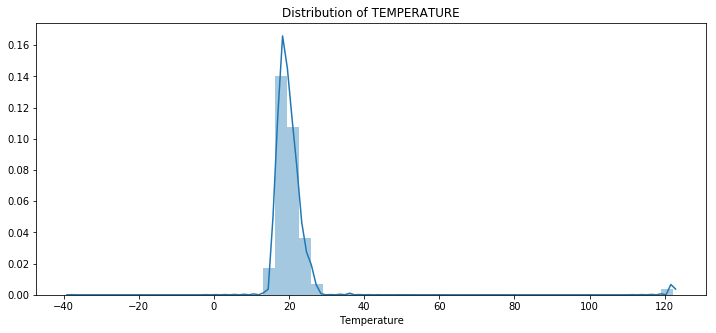

In [102]:
# <a href='#3'>3 Checando por dados Nulos </a>

plt.figure(figsize=(12,5))
plt.title("Distribution of TEMPERATURE")
ax = sns.distplot(data_["Temperature"])


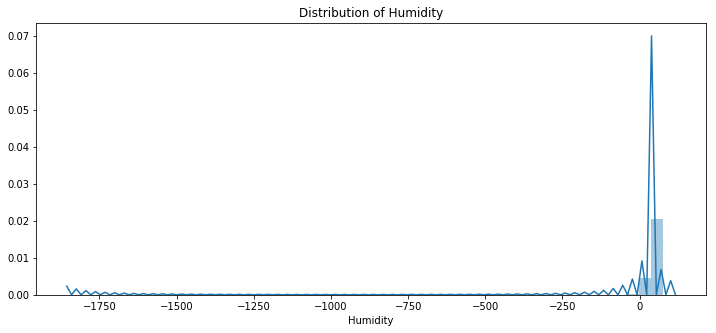

In [101]:
# <a href='#3'>3 Checando por dados Nulos </a>

plt.figure(figsize=(12,5))
plt.title("Distribution of Humidity")
ax = sns.distplot(data_["Humidity"])


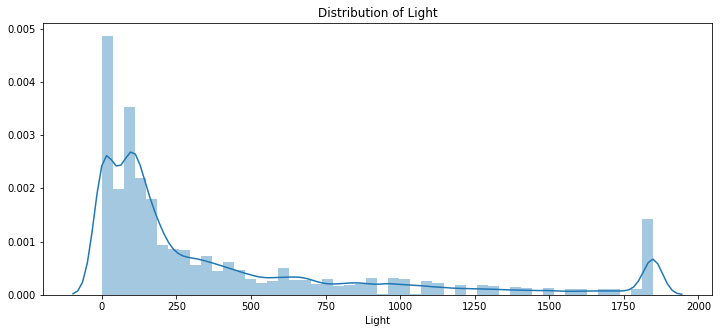

In [100]:
# <a href='#3'>3 Checando por dados Nulos </a>

plt.figure(figsize=(12,5))
plt.title("Distribution of Light")
ax = sns.distplot(data_["Light"])


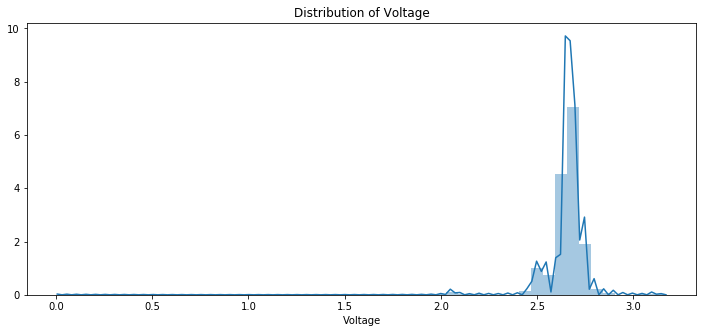

In [99]:
# <a href='#3'>3 Checando por dados Nulos </a>

plt.figure(figsize=(12,5))
plt.title("Distribution of Voltage")
ax = sns.distplot(data_["Voltage"])


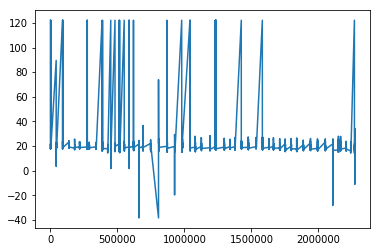

In [98]:
data_["Temperature"].plot()

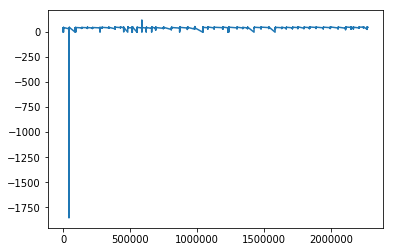

In [97]:
data_["Humidity"].plot()

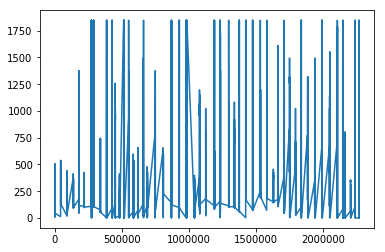

In [95]:
data_["Light"].plot()

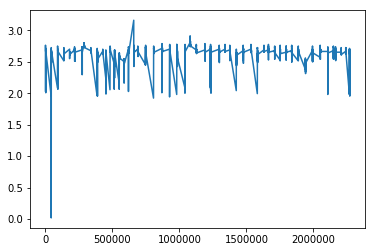

In [94]:
data_["Voltage"].plot()

In [99]:

def iwd(x,y,v,grid,power):
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            distance = np.sqrt((x-i)**2+(y-j)**2)
            if (distance**power).min()==0: 
                grid[i,j] = v[(distance**power).argmin()]
            else:
                total = np.sum(1/(distance**power))
                grid[i,j] = np.sum(v/(distance**power)/total)
    return grid

def SK(x,y,v,variogram,grid):
    cov_angulos = np.zeros((x.shape[0],x.shape[0]))
    cov_distancias = np.zeros((x.shape[0],x.shape[0]))
    K = np.zeros((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]-1):
        cov_angulos[i,i:]=np.arctan2((y[i:]-y[i]),(x[i:]-x[i]))
        cov_distancias[i,i:]=np.sqrt((x[i:]-x[i])**2+(y[i:]-y[i])**2)
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            if cov_distancias[i,j]!=0:
                amp=np.sqrt((variogram[1]*np.cos(cov_angulos[i,j]))**2+(variogram[0]*np.sin(cov_angulos[i,j]))**2)
                K[i,j]=v[:].var()*(1-np.e**(-3*cov_distancias[i,j]/amp))
    K = K + K.T

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
             distancias = np.sqrt((i-x[:])**2+(j-y[:])**2)
             angulos = np.arctan2(i-y[:],j-x[:])
             amplitudes = np.sqrt((variogram[1]*np.cos(angulos[:]))**2+(variogram[0]*np.sin(angulos[:]))**2)
             M = v[:].var()*(1-np.e**(-3*distancias[:]/amplitudes[:]))
             W = LA.solve(K,M)
             grid[i,j] = np.sum(W*(v[:]-v[:].mean()))+v[:].mean()
    return grid

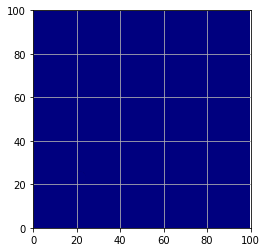

In [105]:

np.random.seed(123433789) # GIVING A SEED NUMBER FOR THE EXPERIENCE TO BE REPRODUCIBLE
grid = np.zeros((100,100),dtype='float32') # float32 gives us a lot precision
# x,y = np.random.randint(0,100,10),np.random.randint(0,100,10) # CREATE POINT SET.
x, y = outliers.X[:10],outliers.Y[:10]
# v = np.random.randint(0,10,10) # THIS IS MY VARIABLE
v = outliers.Temperature[:10]

grid = iwd(x,y,v,grid,2)
plt.imshow(grid.T,origin='lower',interpolation='nearest',cmap='jet')
plt.scatter(x,y,c=v,cmap='jet',s=120)
plt.xlim(0,grid.shape[0])
plt.ylim(0,grid.shape[1])
plt.grid()
plt.show()

In [134]:
outliers.Light[:5][::-1]

4    45.08
3    45.08
2    45.08
1    45.08
0    11.04
Name: Light, dtype: float64

In [136]:

np.random.seed(123433789) # GIVING A SEED NUMBER FOR THE EXPERIENCE TO BE REPRODUCIBLE
grid = np.zeros((100,100),dtype='float32') # float32 gives us a lot precision
# x = np.random.randint(0,100,10)
# ,np.random.randint(0,100,10) # CREATE POINT SET.
# x, y = outliers.X[:10],outliers.Y[:10]
y = outliers.Y[:10]

x = outliers.X[:10][::-1]

# v = np.random.randint(0,10,10) # THIS IS MY VARIABLE
v = outliers.Temperature[:10]

grid = SK(x,y,v,(50,30),grid)
plt.imshow(grid.T,origin='lower',interpolation='nearest',cmap='jet')
plt.scatter(x,y,c=v,cmap='jet',s=120)
plt.xlim(0,grid.shape[0])
plt.ylim(0,grid.shape[1])
plt.grid()
plt.show()

LinAlgError: Matrix is singular.

In [113]:
# !pip install pykrige
import os
from pykrige import OrdinaryKriging


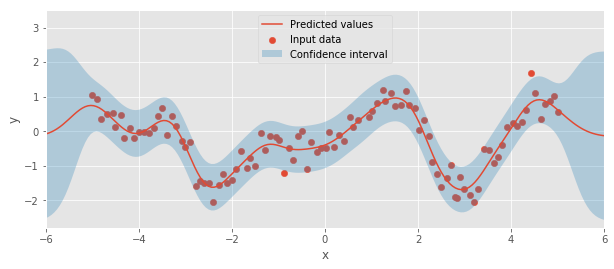

In [114]:
plt.style.use('ggplot')

# Data taken from https://blog.dominodatalab.com/fitting-gaussian-process-models-python/

X, y = np.array([[-5.01, 1.06], [-4.90, 0.92], [-4.82, 0.35], [-4.69, 0.49], [-4.56, 0.52],
     [-4.52, 0.12], [-4.39, 0.47], [-4.32,-0.19], [-4.19, 0.08], [-4.11,-0.19],
     [-4.00,-0.03], [-3.89,-0.03], [-3.78,-0.05], [-3.67, 0.10], [-3.59, 0.44],
     [-3.50, 0.66], [-3.39,-0.12], [-3.28, 0.45], [-3.20, 0.14], [-3.07,-0.28],
     [-3.01,-0.46], [-2.90,-0.32], [-2.77,-1.58], [-2.69,-1.44], [-2.60,-1.51],
     [-2.49,-1.50], [-2.41,-2.04], [-2.28,-1.57], [-2.19,-1.25], [-2.10,-1.50],
     [-2.00,-1.42], [-1.91,-1.10], [-1.80,-0.58], [-1.67,-1.08], [-1.61,-0.79],
     [-1.50,-1.00], [-1.37,-0.04], [-1.30,-0.54], [-1.19,-0.15], [-1.06,-0.18],
     [-0.98,-0.25], [-0.87,-1.20], [-0.78,-0.49], [-0.68,-0.83], [-0.57,-0.15],
     [-0.50, 0.00], [-0.38,-1.10], [-0.29,-0.32], [-0.18,-0.60], [-0.09,-0.49],
     [0.03 ,-0.50], [0.09 ,-0.02], [0.20 ,-0.47], [0.31 ,-0.11], [0.41 ,-0.28],
     [0.53 , 0.40], [0.61 , 0.11], [0.70 , 0.32], [0.94 , 0.42], [1.02 , 0.57],
     [1.13 , 0.82], [1.24 , 1.18], [1.30 , 0.86], [1.43 , 1.11], [1.50 , 0.74],
     [1.63 , 0.75], [1.74 , 1.15], [1.80 , 0.76], [1.93 , 0.68], [2.03 , 0.03],
     [2.12 , 0.31], [2.23 ,-0.14], [2.31 ,-0.88], [2.40 ,-1.25], [2.50 ,-1.62],
     [2.63 ,-1.37], [2.72 ,-0.99], [2.80 ,-1.92], [2.83 ,-1.94], [2.91 ,-1.32],
     [3.00 ,-1.69], [3.13 ,-1.84], [3.21 ,-2.05], [3.30 ,-1.69], [3.41 ,-0.53],
     [3.52 ,-0.55], [3.63 ,-0.92], [3.72 ,-0.76], [3.80 ,-0.41], [3.91 , 0.12],
     [4.04 , 0.25], [4.13 , 0.16], [4.24 , 0.26], [4.32 , 0.62], [4.44 , 1.69],
     [4.52 , 1.11], [4.65 , 0.36], [4.74 , 0.79], [4.84 , 0.87], [4.93 , 1.01],
     [5.02 , 0.55]]).T


from pykrige import OrdinaryKriging

X_pred = np.linspace(-6, 6, 200)

# pykrige doesn't support 1D data for now, only 2D or 3D
# adapting the 1D input to 2D
uk = OrdinaryKriging(X, np.zeros(X.shape), y, variogram_model='gaussian',)

y_pred, y_std = uk.execute('grid', X_pred, np.array([0.]))

y_pred = np.squeeze(y_pred)
y_std = np.squeeze(y_std)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.scatter(X, y, s=40, label='Input data')


ax.plot(X_pred, y_pred, label='Predicted values')
ax.fill_between(X_pred, y_pred - 3*y_std, y_pred + 3*y_std, alpha=0.3, label='Confidence interval')
ax.legend(loc=9)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-6, 6)
ax.set_ylim(-2.8, 3.5)
if 'CI' not in os.environ:
    # skip in continous integration
    plt.show()